In [10]:
import psycopg2 as ps
import psycopg2.extras as e
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

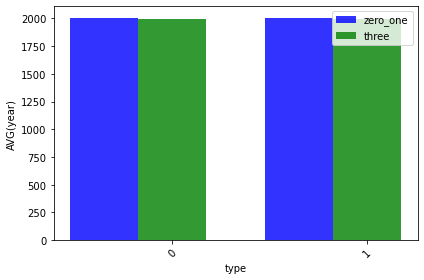

In [12]:
# connect to database
con = ps.connect("dbname='piushagullapalli' user='piushagullapalli' host='localhost' password=''")
cur = con.cursor()

# select
query = """create or replace view zero_one as 
                   select * from venue where type in ('0', '1');
           create or replace view three as 
                   select * from venue where type in ('3');"""
cur.execute(query)
con.commit()

query = "SELECT type, avg(year) FROM zero_one GROUP BY type;"
cur.execute(query)
target_rows = cur.fetchall()

query = "SELECT type, avg(year) FROM three GROUP BY type;"
cur.execute(query)
ref_rows = cur.fetchall()

# util function to plot the view 
def visualize(target_data, ref_data, view_tuple):
    n_groups = len(target_data)
    group_by, measure, function = view_tuple

    means_target = target_data.values()
    means_ref = ref_data.values()

    # create plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8

    rects1 = plt.bar(index, means_target, bar_width,
                     alpha=opacity,
                     color='b',
                     label='zero_one')

    rects2 = plt.bar(index + bar_width, means_ref, bar_width,
                     alpha=opacity,
                     color='g',
                     label='three')

    plt.xlabel('{}'.format(group_by))
    plt.ylabel('{}({})'.format(function, measure))
    plt.xticks(index + bar_width, target_data.keys(), rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()


view_tuple = ('type', 'year', 'AVG')
visualize(dict(target_rows), dict(ref_rows), view_tuple)